In [1]:
!python -V

Python 3.13.5


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [6]:
df = pd.read_parquet('./data/yellow_tripdata_2023-01.parquet')
column_count = len(df.columns)

In [7]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
standard_deviation = df.duration.describe().loc['std']

In [8]:
fraction_1_to_60_min = ((df.duration >= 1) & (df.duration <= 60)).mean()
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [9]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [10]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
feature_matrix_column_count = X_train.shape
target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

rmse_on_train = root_mean_squared_error(y_train, y_pred)

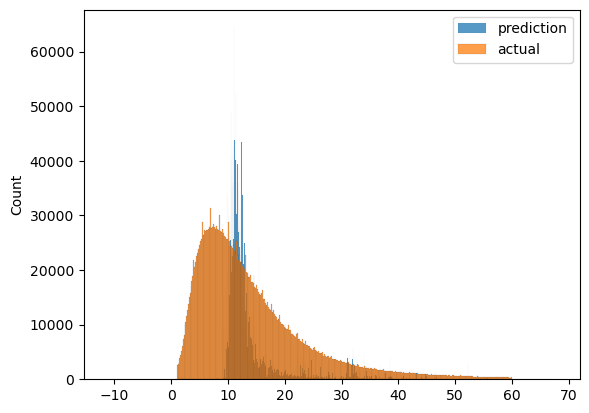

In [11]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend()

In [12]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [13]:
df_train = read_dataframe('./data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('./data/yellow_tripdata_2023-02.parquet')

In [14]:
len(df_train), len(df_val)

(3009173, 2855951)

In [15]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [16]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [17]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

rmse_on_validation = root_mean_squared_error(y_val, y_pred)

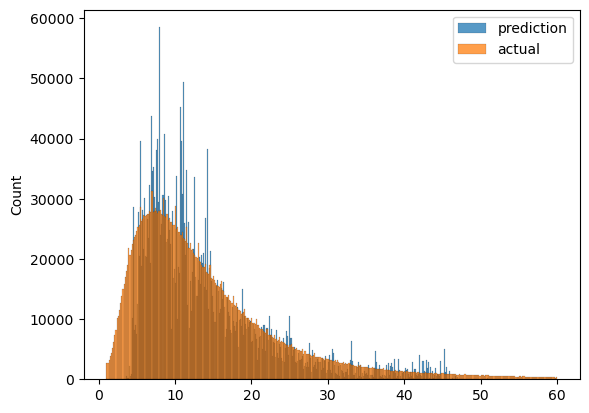

In [19]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend()

In [20]:
with open('./models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [21]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

9.395699095576239

In [23]:
print("Q1 Number of columns--------------------------" + str(column_count))
print("Q2 Standard deviation for all trips duration--" + str(round(standard_deviation, 2)))
print("Q3 Fraction left after droping outliers-------" + str(round(fraction_1_to_60_min, 4)))
print("Q4 Dimensionality of feature matrix-----------" + str(feature_matrix_column_count))
print("Q5 RMSE on train------------------------------" + str(round(rmse_on_train, 2)))
print("Q6 RMSE on validation-------------------------" + str(round(rmse_on_validation, 2)))

Q1 Number of columns--------------------------19
Q2 Standard deviation for all trips duration--42.59
Q3 Fraction left after droping outliers-------0.9812
Q4 Dimensionality of feature matrix-----------(3009173, 516)
Q5 RMSE on train------------------------------7.66
Q6 RMSE on validation-------------------------5.25
